## How to create a mask for CESM1's "urban areas"?

This script is used for creating a urban mask at the global scale for CESM1 data.  

Reference:      
- GitHub: https://github.com/ncar/cesm-lens-aws/        
- (outdated) Reproduce CESM-LENS: http://gallery.pangeo.io/repos/NCAR/cesm-lens-aws/notebooks/kay-et-al-2015.v3.html

**Step 0: load necessary packages and define parameters**

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import intake
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# define parameters for data retrieval
catalog_url = 'https://raw.githubusercontent.com/NCAR/cesm-lens-aws/main/intake-catalogs/aws-cesm1-le.json'
experiment = "RCP85"
frequency = "daily"
urban_variable = "TREFMXAV_U"
cam_variable = "TREFHT"

**Step 1: load datasets**

In [2]:
col = intake.open_esm_datastore(catalog_url)
col_subset = col.search(experiment=experiment, frequency=frequency, variable=urban_variable)
dsets = col_subset.to_dataset_dict(zarr_kwargs={"consolidated": True}, 
                                   storage_options={"anon": True})["lnd.RCP85.daily"]


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'


**Step 2: find the urban gridcell**  
Given that urban gridcell is **time-invariant**, let's use `member_id = 2` and `time="2006-01-02"`

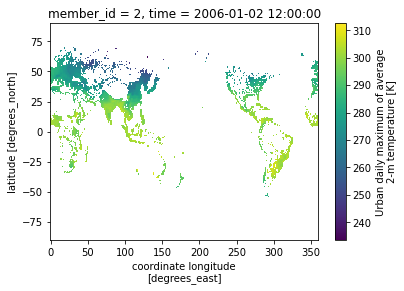

In [3]:
da = dsets.sel(member_id=2, time="2006-01-02")[urban_variable].load()
da.plot()

**Step 3: save the urban mask**  
The file is save at current working directory, with a file name "urban_mask.nc"

In [4]:
da.notnull().squeeze().drop(["time","member_id"]).rename("mask").to_netcdf("./CESM1_urban_mask.nc")

**Step 4: load the urban mask**

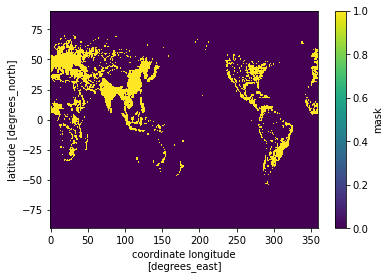

In [5]:
mask = xr.open_dataset("./CESM1_urban_mask.nc")["mask"]
mask.plot()

**Step 5: apply the urban mask to CAM**

load CAM data


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'


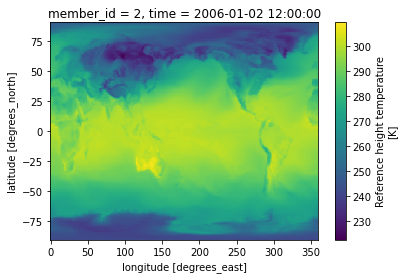

In [6]:
col_subset = col.search(experiment=experiment, frequency=frequency, variable=cam_variable)
dsets = col_subset.to_dataset_dict(zarr_kwargs={"consolidated": True}, 
                                   storage_options={"anon": True})['atm.RCP85.daily']
da_cam = dsets.sel(member_id=2, time="2006-01-02")[cam_variable].load()
da_cam.plot()

apply the mask to CAM data and calculate the difference

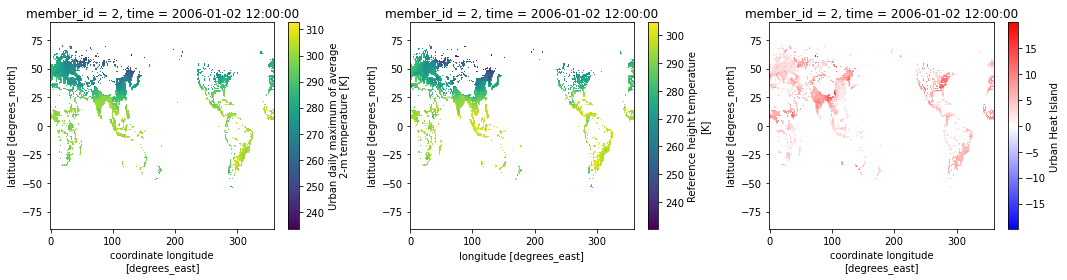

In [7]:
da_cam_urban = da_cam.where(mask)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))
da.plot(ax=ax1)
da_cam_urban.plot(ax=ax2)
(da-da_cam_urban).rename("Urban Heat Island").plot(ax=ax3, cmap="bwr")
plt.tight_layout()

check the dimension

In [8]:
print("city number:", da.to_dataframe().dropna().shape[0])
assert (da-da_cam_urban).rename("Urban Heat Island").to_dataframe().dropna().shape[0] == 4439

city number: 4439
